In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.pipeline import make_pipeline

### Functions used to summaries results:

In [3]:
def accuracy(model, y_test, x_test):
    pred = model.predict(x_test)
    mse = mean_squared_error(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)
    if model.__class__.__name__ == 'RegressionResultsWrapper':
        print('Multiple linear regression\n---------------------')
    
    else:
        print('Lasso regression')
        
    
    print(f'Mean Squared Error: {round(mse,2)} \nMean Absolute Percentage Error: {round(mape*100,2)}%')

In [4]:
df = pd.read_csv('insurance_dataset.csv')
df

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,None,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,None,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,None,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,59,male,46.67,2,no,northeast,High blood pressure,None,Frequently,Student,Basic,11584.134900
999996,33,male,36.83,2,no,northeast,None,High blood pressure,Frequently,Unemployed,Basic,9834.871456
999997,39,male,39.84,0,yes,northeast,Heart disease,High blood pressure,Rarely,Blue collar,Standard,22076.632856
999998,37,female,45.06,4,yes,northeast,High blood pressure,Diabetes,Occasionally,Unemployed,Premium,20297.618728


## Medical insurance charges
- **Age**: The age of the insured individual.
- **Gender**: The gender of the insured individual.
- **BMI** (Body Mass Index): A measure of body fat based on height and weight.
- **Children**: The number of children covered by the insurance plan.
- **Smoking Status**: Indicates whether the individual is a smoker.
- **Region**: The geographical region of the insured individual.
- **Medical History**: Information about the individual's old medical problems.
- **Family Medical History**: Information about the family's medical record.
- **Exercise Frequency**: The frequency of the individual's exercise routine.
- **Occupation**: The occupation of the insured individual.
- **Coverage Level**: The type of insurance plan.
- **Charges**: The health insurance charges for the individual

Data is from Kaggle: https://www.kaggle.com/datasets/sridharstreaks/insurance-data-for-machine-learning/data


## Possible questions:

1. Insurance industry today is full of data on their customers. What we aim to do is to figure out if an insurance company can leverage this data to automate decissions. We will look at whether there is machine learning models that can accuratly set the "coverage_level" of a customer, and if a model can, with good accuracy, set a "charge" to a customer. 

- TSNE to convert data to 2D plane and use clustering to predict future data points "coverage_level".

- Some regression to predict charge.

- Discuss whether the accuracy is good enough for this model to be used by a company. Are there ethical problems with this? Like is it a problem that the model can set higher charges at times due to predictions being somehwat unaccurate. Should we use some regression type, like ridge, to lower the predictions such that this ethical issue is minimized. This could be justified by the savings the company gets from automizing the process.

- Is it ethical to use familiy records to set price

- Se lovverket hva som er lov å diskriminere mot

## Regressions

In [5]:
# Divide into dependent and independent vairables
X = df.drop('charges', axis=1)
y = df['charges']

# Split data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.30)
X_train['charges'] = y_train
training = X_train.copy()

In [6]:
# Good way to code regression with categorical variables
formula = 'charges ~ age + C(gender) + bmi + children + C(smoker) + C(region) + C(medical_history) + C(family_medical_history) + C(exercise_frequency) + C(occupation) + C(coverage_level)'
model = smf.ols(formula = formula, data = training).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 7.400e+06
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:32:53   Log-Likelihood:            -4.9590e+06
No. Observations:              700000   AIC:                         9.918e+06
Df Residuals:                  699977   BIC:                         9.918e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          1.05e+04      2.306   4552.664      0.000    1.05e+04    1.05e+04
C(gender)[T.male]                                  998.9721      0.690   1447.507      0.000     997.619    1000.325
C(smoker)[T.yes]                                  4999.2601      0.690   7243.895      0.000    4997.907    5000.613
C(region)[T.northwest]                            -699.4392      0.976   -716.789      0.000    -701.352    -697.527
C(region)[T.southeast]                            -498.1558      0.976   -510.356      0.000    -500.069    -496.243
C(region)[T.southwest]                            -798.6913      0.976   -818.556      0.000    -800.604    -796.779
C(medical_history)[T.Heart disease]               3001.0637      0.977   3073.163      0.000    2999.150    3002.978
C(medical_history)[T.High blood pressure]        -1001.0192      0.976  -1025.428      0.000   -1002.932    -999.106
C(medical_history)[T.None]                       -1999.5488      0.976  -2049.070      0.000   -2001.461   -1997.636
C(family_medical_history)[T.Heart disease]        3000.9744      0.976   3073.365      0.000    2999.061    3002.888
C(family_medical_history)[T.High blood pressure]  -999.3787      0.976  -1023.874      0.000   -1001.292    -997.466
C(family_medical_history)[T.None]                -1999.8761      0.976  -2049.222      0.000   -2001.789   -1997.963
C(exercise_frequency)[T.Never]                   -1999.7678      0.977  -2046.700      0.000   -2001.683   -1997.853
C(exercise_frequency)[T.Occasionally]             -998.3664      0.976  -1023.224      0.000   -1000.279    -996.454
C(exercise_frequency)[T.Rarely]                  -1498.7437      0.975  -1537.717      0.000   -1500.654   -1496.833
C(occupation)[T.Student]                          -998.3344      0.976  -1023.352      0.000   -1000.246    -996.422
C(occupation)[T.Unemployed]                      -1498.9032      0.976  -1536.285      0.000   -1500.815   -1496.991
C(occupation)[T.White collar]                      501.6974      0.977    513.674      0.000     499.783     503.612
C(coverage_level)[T.Premium]                      5000.1105      0.846   5913.702      0.000    4998.453    5001.768
C(coverage_level)[T.Standard]                     2000.1848      0.845   2367.098      0.000    1998.529    2001.841
age                                                 19.9931      0.025    802.601      0.000      19.944      20.042
bmi                                                 49.9872      0.037   1337.198      0.000      49.914      50.061
children                                           200.1930      0.202    991.316      0.000     199.797     200.589
=========================================

In [7]:
# Out-of-sample testing
accuracy(model, y_test, X_test)

Multiple linear regression
---------------------
Mean Squared Error: 83383.5 
Mean Absolute Percentage Error: 1.62%


## Regularization with Lasso


Previously we used multiple linear regression to make our model by the OLS method. The model follows the format:
$$y = \alpha + \beta_1 x_1 + \beta_2 x_2 + ... \beta_n x_n$$
Where the $\beta$ parameters are set to minimize its cost function:
$$ \sum_{i=1}^n(y_i - \hat{y}_i)^2 $$
In regularization we add a penalty term to the cost function and try to minimize it. With Lasso, the cost function we will work with is:
$$ \sum_{i=1}^n(y_i - \hat{y}_i)^2 + \alpha \sum_{i=1}^n |\beta_i| $$ 

If a feature is less significant, it is shrunk towards zero. As a result, features whos coefficients have been shrunk to zero are functionally removed from the model, essentially performing feature selection. 


In [8]:
X = df.drop('charges', axis=1)
y = df['charges']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)
X

,age,bmi,children,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest,medical_history_Heart disease,medical_history_High blood pressure,...,family_medical_history_High blood pressure,family_medical_history_None,exercise_frequency_Never,exercise_frequency_Occasionally,exercise_frequency_Rarely,occupation_Student,occupation_Unemployed,occupation_White collar,coverage_level_Premium,coverage_level_Standard
0,46,21.45,5,1,1,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
1,25,25.38,2,0,1,1,0,0,0,0,...,1,0,0,1,0,0,0,1,1,0
2,38,44.88,2,1,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
3,25,19.89,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
4,49,38.21,3,1,1,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,59,46.67,2,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
999996,33,36.83,2,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
999997,39,39.84,0,1,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
999998,37,45.06,4,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,0


In [9]:

lasso = Lasso(max_iter=10000)

# Lasso cross validation
test_alphas = np.linspace(0.01,4, 50)
lassocv = LassoCV(alphas=test_alphas, cv=10, max_iter=100000)

lassocv.fit(X, y)

LassoCV(alphas=array([0.01      , 0.09142857, 0.17285714, 0.25428571, 0.33571429,
       0.41714286, 0.49857143, 0.58      , 0.66142857, 0.74285714,
       0.82428571, 0.90571429, 0.98714286, 1.06857143, 1.15      ,
       1.23142857, 1.31285714, 1.39428571, 1.47571429, 1.55714286,
       1.63857143, 1.72      , 1.80142857, 1.88285714, 1.96428571,
       2.04571429, 2.12714286, 2.20857143, 2.29      , 2.37142857,
       2.45285714, 2.53428571, 2.61571429, 2.69714286, 2.77857143,
       2.86      , 2.94142857, 3.02285714, 3.10428571, 3.18571429,
       3.26714286, 3.34857143, 3.43      , 3.51142857, 3.59285714,
       3.67428571, 3.75571429, 3.83714286, 3.91857143, 4.        ]),
        cv=10, max_iter=100000)

In [10]:
# Alpha value choosen by the cross validation
# Choose the smallest alpha given as an option, showing little willingness to put less importance on any variables
lassocv.alpha_

0.01

In [11]:
lasso.set_params(alpha = lassocv.alpha_)

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X,y, test_size= 0.30)

lasso.fit(X_train_l, y_train_l)

accuracy(lasso, y_test_l, X_test_l)

Lasso regression
Mean Squared Error: 83478.22 
Mean Absolute Percentage Error: 1.62%


#### Interpretation

Seems Lasso yields little improvement from the basic OLS model. This is of no suprise as on the summary for the OLS model it seemed to strongly indicate that all variables are important. Since Lasso is a linear regression with a penalty term that helps to prevent overfitting and facilitate automatic feature selection, it is not suprising that it did not yield much improvements as all features in the dataset seems important.

## Regression with Ridge regularization 

In [12]:
alphas = np.logspace(-4, 1, 100)
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')).fit(X_train_l, y_train_l)

best_alpha_ridge = ridge_cv[-1].alpha_
ridge_model = Ridge(alpha=best_alpha_ridge).fit(X_train_l, y_train_l)

y_pred_ridge = ridge_model.predict(X_test_l)
ridge_mse = mean_squared_error(y_test_l, y_pred_ridge)

print(f"Best alpha for Ridge Regression: {round(best_alpha_ridge,5)}")
print(f"Mean Squared Error on test data: {round(ridge_mse,2)}")

Best alpha for Ridge Regression: 0.08498
Mean Squared Error on test data: 83478.23


In [13]:
#Ridge with same alpha as for Lasso regression
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')).fit(X_train_l, y_train_l)
ridge_model = Ridge(alpha=best_alpha_ridge).fit(X_train_l, y_train_l)
y_pred_ridge = ridge_model.predict(X_test_l)
ridge_mse = mean_squared_error(y_test_l, y_pred_ridge)
accuracy(ridge_model, y_test_l, X_test_l)

Lasso regression
Mean Squared Error: 83478.23 
Mean Absolute Percentage Error: 1.62%


---------

In [14]:
df = pd.read_csv('insurance_dataset.csv')
X = df.drop('charges', axis=1)
y = df['charges']

In [15]:
df['Predicted'] = model.predict(X)
df['difference'] = df.charges - df.Predicted
df['Absolute_error'] = np.abs(df.charges - df.Predicted)
df['Absolute_error%'] = (np.abs(df.charges - df.Predicted)/df.charges)*100

In [16]:
top_error = df.sort_values('Absolute_error%', ascending=False).head(1000)
top_error

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges,Predicted,difference,Absolute_error,Absolute_error%
118128,22,female,20.79,1,no,southwest,None,None,Never,Unemployed,Basic,3445.011643,3880.421972,-435.410329,435.410329,12.638864
411715,19,female,25.51,0,no,northwest,None,None,Rarely,Unemployed,Basic,3964.120643,4456.465766,-492.345123,492.345123,12.420034
68563,24,female,20.11,0,no,northeast,None,None,Never,Unemployed,Basic,4011.061723,4484.915135,-473.853411,473.853411,11.813665
937228,60,female,26.72,0,no,southwest,None,None,Never,Unemployed,Basic,4239.003752,4736.389922,-497.386170,497.386170,11.733563
456579,27,female,19.17,0,no,southwest,High blood pressure,None,Never,Unemployed,Basic,4218.374495,4697.744614,-479.370120,479.370120,11.363859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249900,30,female,24.49,3,no,southwest,None,None,Occasionally,Student,Basic,6570.725745,6127.675408,443.050337,443.050337,6.742791
960943,38,female,22.93,4,no,northeast,None,High blood pressure,Rarely,Unemployed,Basic,6752.756197,7208.075524,-455.319327,455.319327,6.742718
926994,40,female,32.83,0,no,southwest,None,None,Rarely,Blue collar,Basic,7122.100862,6641.877826,480.223036,480.223036,6.742716
170842,62,male,25.61,0,no,southeast,None,None,Rarely,Student,Basic,6578.444828,7021.990622,-443.545795,443.545795,6.742411


Most of the highest errors came from predicting hgiher charges than there actually were.

In [17]:
top_error.groupby('gender').count()['Absolute_error%']

gender
female    811
male      189
Name: Absolute_error%, dtype: int64

Even though the dataset contains roughly 50/50 male and female, 81% of the 1000 biggest error done by the model are predictions on cases where the gender is female. 

In [18]:
top_error[top_error['gender'] == 'female'].difference.mean()

-252.10976157800366

Seems that the biggest errors our model has is due to predicting higher charges for females than what actually occurs in the data.

In [19]:
test_predictions = model.predict(X_test)

In [23]:
X_test['predictions'] = test_predictions
X_test['True Y'] = y_test

In [25]:
X_test['difference'] = X_test['True Y'] - X_test.predictions

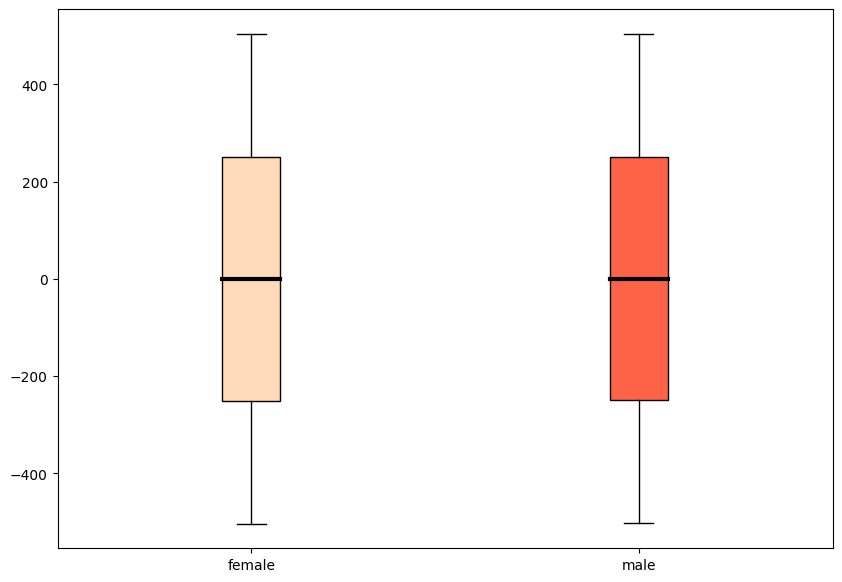

In [50]:
female = X_test[X_test['gender'] == 'female'].difference
male = X_test[X_test['gender'] == 'male'].difference

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

data = [female, male]
bplot = ax.boxplot(data,
                   patch_artist=True)

ax.set_xticklabels(['female', 'male'])

for patch, color in zip(bplot['boxes'], ['peachpuff', 'tomato']):
    patch.set_facecolor(color)

for median in bplot['medians']:
    median.set(color ='black',
               linewidth = 3)

plt.show()

For our predictions with the test dataset, it seems that the errors are equal for male and female, further hinting that the true charges does take into account the gender of the customer. 